### **Dataset from:**
### 1. https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
### 2. https://www.kaggle.com/datasets/muhammadrehan00/chest-xray-dataset

## **Notebook setup**

In [6]:
import sys
from pathlib import Path

cwd = Path().resolve()

for parent in [cwd] + list(cwd.parents):
    if (parent / "src").exists():
        ROOT_DIR = parent
        break

sys.path.insert(0, str(ROOT_DIR))

print("ROOT_DIR:", ROOT_DIR)

ROOT_DIR: E:\My Documents\skripsi\model_penelitian


## **Import Required Libraries**

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from src.training.train import train_model
from src.models.resnet50 import build_model
from src.config.load_config import load_config
from src.training.callbacks import get_callbacks
from src.data.dataset_loader import create_generators

config = load_config()

import warnings
warnings.filterwarnings("ignore")

In [8]:
df_path = ROOT_DIR / config["paths"]["dataset_csv"]
df = pd.read_csv(df_path)
df.head()

,img_path,height,width,image_size_kb,label
0,E:/My Documents/skripsi/model_penelitian/data/...,224,224,18.304,Pneumonia
1,E:/My Documents/skripsi/model_penelitian/data/...,224,224,17.378,Pneumonia
2,E:/My Documents/skripsi/model_penelitian/data/...,224,224,11.873,Normal
3,E:/My Documents/skripsi/model_penelitian/data/...,224,224,14.458,Normal
4,E:/My Documents/skripsi/model_penelitian/data/...,224,224,18.549,Normal


## **Split Dataset**

In [9]:
df_train_val, df_test = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=42,
)

df_train, df_val = train_test_split(
    df_train_val,
    test_size=0.25,
    stratify=df_train_val["label"],
    random_state=42,
)

print(f"Train set size: {len(df_train)}")
print(f"Val set size: {len(df_val)}")
print(f"Test set size: {len(df_test)}")

Train set size: 12460
Val set size: 4154
Test set size: 4154


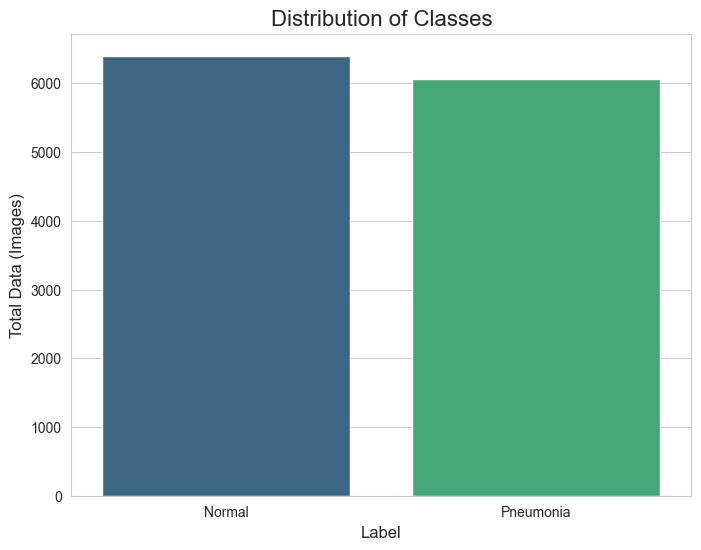

In [10]:
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(x=["Normal", "Pneumonia"], y=df_train["label"].value_counts().sort_index(), palette="viridis")
plt.title("Distribution of Classes", fontsize=16)
plt.xlabel("Label", fontsize=12)
plt.ylabel("Total Data (Images)", fontsize=12)
plt.show()

# **Experiment 01**

## **Augmentation**

In [ ]:
train_generator, val_generator, test_generator = create_generators(
    df_train,
    df_val,
    df_test,
)

Found 12460 validated image filenames belonging to 2 classes.
Found 4154 validated image filenames belonging to 2 classes.
Found 4154 validated image filenames belonging to 2 classes.


## **Modelling**

In [ ]:
model = build_model(model_name="resnet50_classifier",)

model.summary()

Model: "ResNet50_chest_xray_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
history = train_model(
    model,
    train_generator,
    val_generator,
    callbacks=get_callbacks(),
)

Epoch 1/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 1389s 4s/step - accuracy: 0.8676 - loss: 0.2825 - precision: 0.8626 - recall: 0.8655 - val_accuracy: 0.8946 - val_loss: 0.2242 - val_precision: 0.9294 - val_recall: 0.8474 - learning_rate: 1.0000e-04
Epoch 2/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 1222s 3s/step - accuracy: 0.8922 - loss: 0.2210 - precision: 0.8959 - recall: 0.8807 - val_accuracy: 0.8960 - val_loss: 0.2226 - val_precision: 0.9506 - val_recall: 0.8291 - learning_rate: 1.0000e-04
Epoch 3/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8992 - loss: 0.2124 - precision: 0.9138 - recall: 0.8754
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
390/390 ━━━━━━━━━━━━━━━━━━━━ 1212s 3s/step - accuracy: 0.9010 - loss: 0.2064 - precision: 0.9159 - recall: 0.8769 - val_accuracy: 0.9013 - val_loss: 0.2047 - val_precision: 0.9553 - val_recall: 0.8361 - learning_rate: 1.0000e-04
Epoch 4/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 1238s 3s/step - accuracy: 0.9039 - loss: 0.1967 - pre

## **Evaluate**

In [20]:
loss, accuracy, recall, precision = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}, Test Recall: {recall:.4f}, Test Precision: {precision:.4f}")

130/130 ━━━━━━━━━━━━━━━━━━━━ 359s 3s/step - accuracy: 0.9006 - loss: 0.2039 - precision: 0.9452 - recall: 0.8446
Test Loss: 0.2039, Test Accuracy: 0.9006, Test Recall: 0.8446, Test Precision: 0.9452


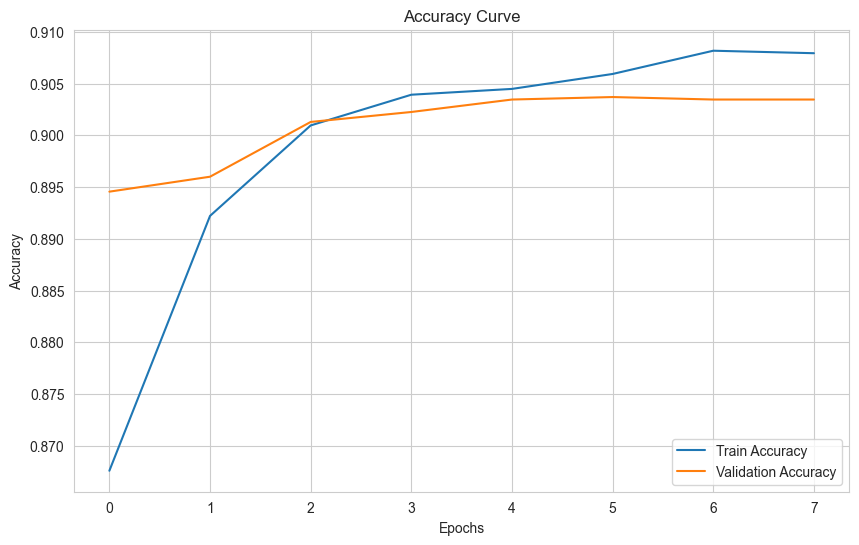

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend(loc="lower right")
plt.show()

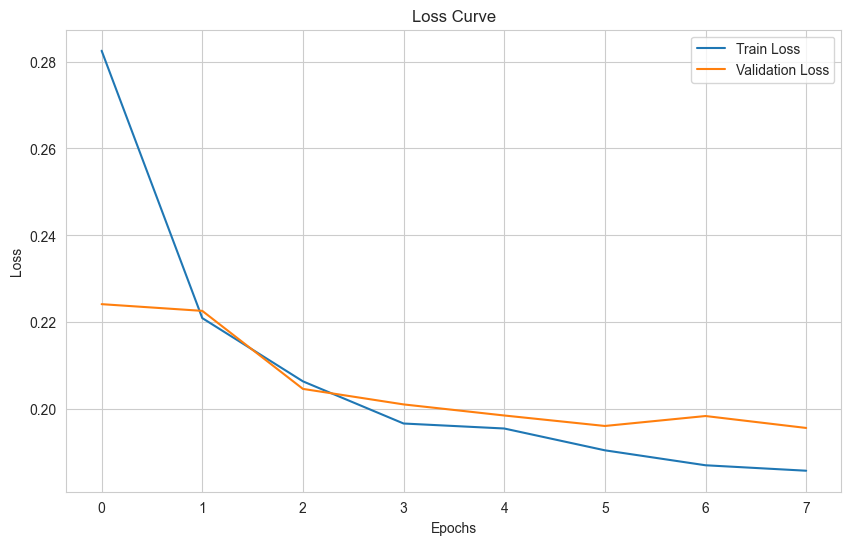

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend(loc="upper right")
plt.show()

In [24]:
y_true = test_generator.classes
y_prob = model.predict(test_generator, steps=len(test_generator))
y_pred_classes = (y_prob > 0.5).astype(int).flatten()

cm = confusion_matrix(y_true, y_pred_classes)
auc = roc_auc_score(y_true, y_prob)

print("-" * 50)
print(f"ROC-AUC Score: {auc:.4f}")
print(f"Confusion Matrix:\n{cm}")

130/130 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step
--------------------------------------------------
ROC-AUC Score: 0.9703
Confusion Matrix:
[[2035   99]
 [ 314 1706]]


In [25]:
fpr, tpr, thresholds = roc_curve(y_true, y_prob)

J = tpr - fpr
ix = np.argmax(J)
print(f"Best Threshold: {thresholds[ix]:.4f}, G-Mean: {np.sqrt(tpr[ix]* (1-fpr[ix])):.4f}")
print(f"TPR: {tpr[ix]:.4f}, FPR: {fpr[ix]:.4f}")

Best Threshold: 0.5381, G-Mean: 0.8980
TPR: 0.8366, FPR: 0.0361


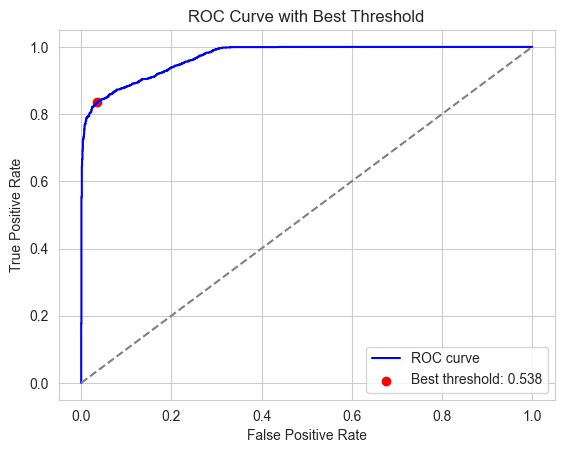

In [26]:
plt.plot(fpr, tpr, color='blue', label='ROC curve')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label=f'Best threshold: {thresholds[ix]:.3f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Best Threshold')
plt.legend()
plt.show()

In [27]:
print(classification_report(y_true, y_pred_classes, target_names=["Normal", "Pneumonia"]))

              precision    recall  f1-score   support

      Normal       0.87      0.95      0.91      2134
   Pneumonia       0.95      0.84      0.89      2020

    accuracy                           0.90      4154
   macro avg       0.91      0.90      0.90      4154
weighted avg       0.90      0.90      0.90      4154



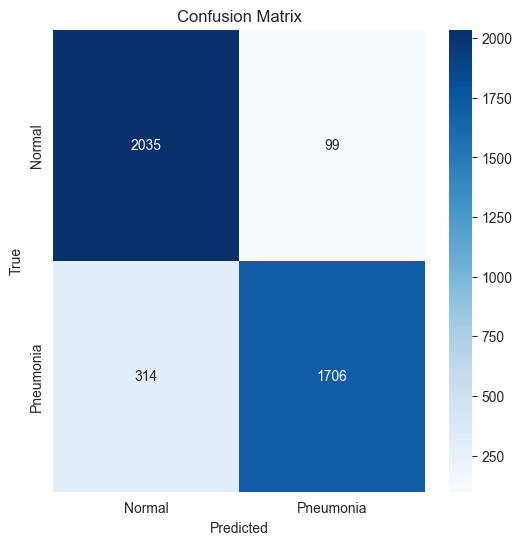

In [28]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..147.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..140.061].


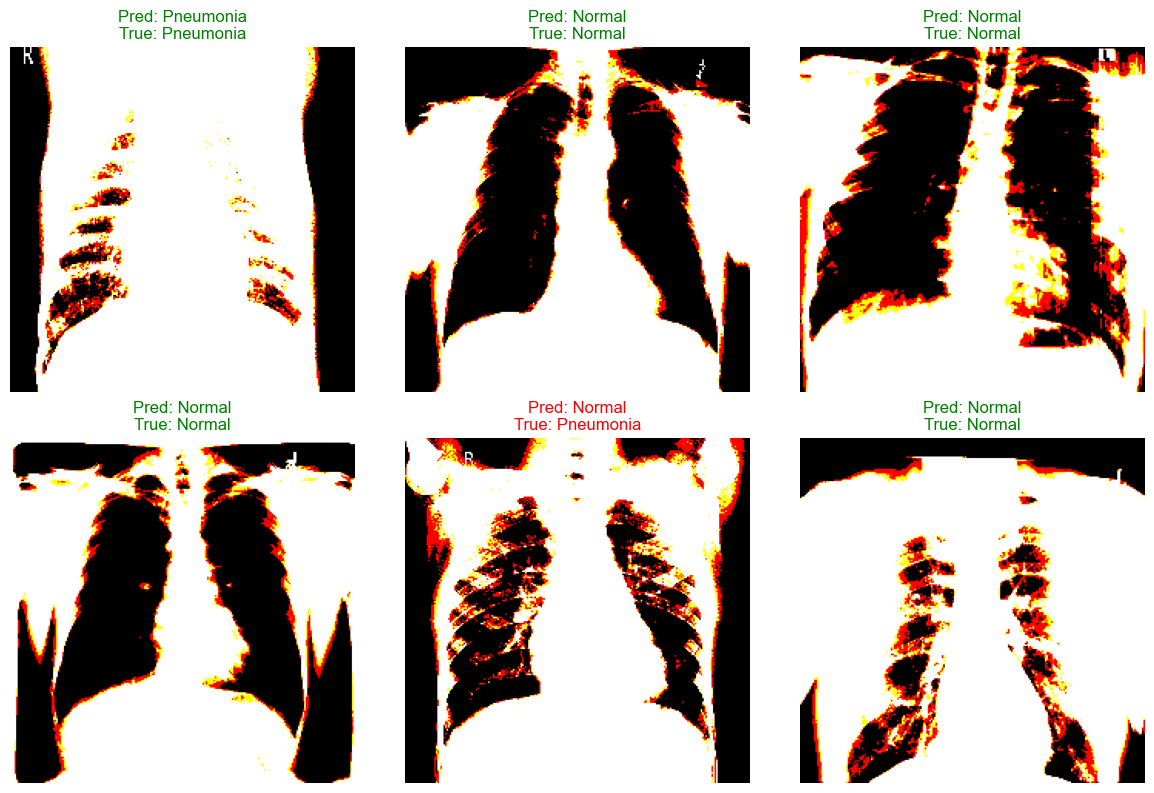

In [29]:
batch_images = test_generator[0][0] 

plt.figure(figsize=(12, 8))

for i in range(6):
    plt.subplot(2, 3, i + 1)

    predicted_label = "Pneumonia" if y_pred_classes[i] == 1 else "Normal"
    true_label = "Pneumonia" if y_true[i] == 1 else "Normal"
    
    color = "green" if predicted_label == true_label else "red"
    
    plt.imshow(batch_images[i]) 
    plt.title(f"Pred: {predicted_label}\nTrue: {true_label}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()

# **Experiment 02**

## **No Augmentation**

In [42]:
datagen_no_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

In [43]:
train_generator_no_aug = datagen_no_aug.flow_from_dataframe(
    df_train,
    x_col="img_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    class_mode="binary"
)

val_generator_no_aug = datagen_no_aug.flow_from_dataframe(
    df_val,
    x_col="img_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    shuffle=False,
    class_mode="binary"
)

test_generator_no_aug = datagen_no_aug.flow_from_dataframe(
    df_test,
    x_col="img_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    shuffle=False,
    class_mode="binary"
)

Found 12460 validated image filenames belonging to 2 classes.
Found 4154 validated image filenames belonging to 2 classes.
Found 4154 validated image filenames belonging to 2 classes.


## **Modelling**

In [44]:
model_no_aug = build_model(
    model_name="ResNet50_chest_xray_classifier_no_aug",
    dropout_rate=0.3,
    learning_rate=LEARNING_RATE,
    img_shape=IMG_SHAPE,
)

model_no_aug.summary()

Model: "ResNet50_chest_xray_classifier_no_aug"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [45]:
callbacks_list_without_aug = callbacks_list()

history_no_aug = model_no_aug.fit(
    train_generator_no_aug,
    validation_data=val_generator_no_aug,
    epochs=EPOCHS,
    callbacks=callbacks_list_without_aug,
    shuffle=True,
)

Epoch 1/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 1255s 3s/step - accuracy: 0.8803 - loss: 0.2634 - precision: 0.8771 - recall: 0.8765 - val_accuracy: 0.8895 - val_loss: 0.2187 - val_precision: 0.8816 - val_recall: 0.8925 - learning_rate: 1.0000e-04
Epoch 2/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 1173s 3s/step - accuracy: 0.9001 - loss: 0.2077 - precision: 0.9092 - recall: 0.8826 - val_accuracy: 0.8977 - val_loss: 0.2050 - val_precision: 0.9037 - val_recall: 0.8836 - learning_rate: 1.0000e-04
Epoch 3/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9023 - loss: 0.1958 - precision: 0.9158 - recall: 0.8799
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
390/390 ━━━━━━━━━━━━━━━━━━━━ 1472s 4s/step - accuracy: 0.9028 - loss: 0.1949 - precision: 0.9182 - recall: 0.8783 - val_accuracy: 0.9011 - val_loss: 0.1987 - val_precision: 0.9346 - val_recall: 0.8564 - learning_rate: 1.0000e-04
Epoch 4/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 1781s 5s/step - accuracy: 0.9108 - loss: 0.1819 - pre

## **Evaluate**

In [46]:
loss_no_aug, accuracy_no_aug, recall_no_aug, precision_no_aug = model_no_aug.evaluate(test_generator_no_aug, steps=len(test_generator_no_aug))

print(f"Test Loss: {loss_no_aug:.4f}, Test Accuracy: {accuracy_no_aug:.4f}, Test Recall: {recall_no_aug:.4f}, Test Precision: {precision_no_aug:.4f}")

130/130 ━━━━━━━━━━━━━━━━━━━━ 431s 3s/step - accuracy: 0.8844 - loss: 0.2271 - precision: 0.8816 - recall: 0.8807
Test Loss: 0.2271, Test Accuracy: 0.8844, Test Recall: 0.8807, Test Precision: 0.8816


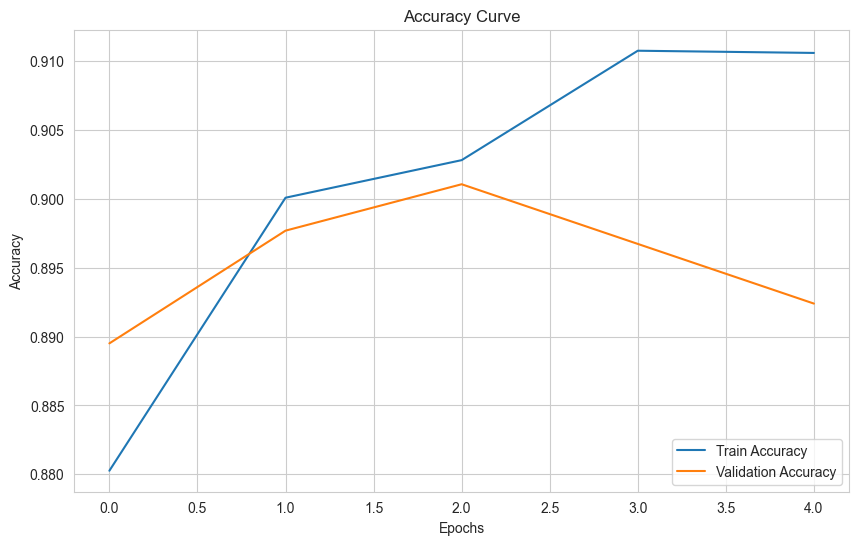

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(history_no_aug.history["accuracy"], label="Train Accuracy")
plt.plot(history_no_aug.history["val_accuracy"], label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend(loc="lower right")
plt.show()

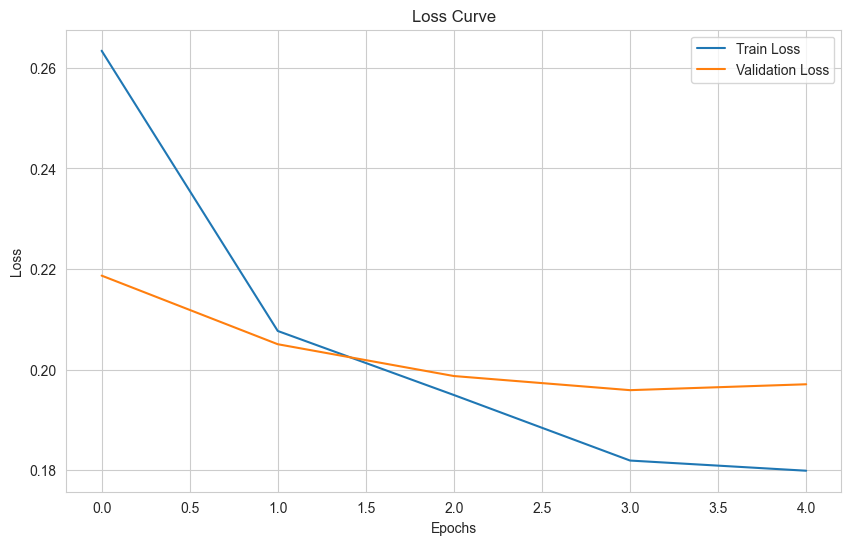

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(history_no_aug.history["loss"], label="Train Loss")
plt.plot(history_no_aug.history["val_loss"], label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend(loc="upper right")
plt.show()

In [50]:
y_true_no_aug = test_generator_no_aug.classes
y_prob_no_aug = model_no_aug.predict(test_generator_no_aug, steps=len(test_generator_no_aug))
y_pred_classes_no_aug = (y_prob_no_aug > 0.5).astype(int).flatten()

cm_without_aug = confusion_matrix(y_true_no_aug, y_pred_classes_no_aug)
auc_without_aug = roc_auc_score(y_true_no_aug, y_prob_no_aug)

print("-" * 50)
print(f"ROC-AUC Score: {auc_without_aug:.4f}")
print(f"Confusion Matrix:\n{cm_without_aug}")

130/130 ━━━━━━━━━━━━━━━━━━━━ 480s 4s/step
--------------------------------------------------
ROC-AUC Score: 0.9665
Confusion Matrix:
[[1895  239]
 [ 241 1779]]


In [51]:
fpr_without_aug, tpr_without_aug, thresholds_without_aug = roc_curve(y_true, y_prob)

J = tpr_without_aug - fpr_without_aug
ix = np.argmax(J)
print(f"Best Threshold: {thresholds_without_aug[ix]:.4f}, G-Mean: {np.sqrt(tpr_without_aug[ix]* (1-fpr_without_aug[ix])):.4f}")
print(f"TPR_without_aug: {tpr_without_aug[ix]:.4f}, FPR: {fpr_without_aug[ix]:.4f}")

Best Threshold: 0.5381, G-Mean: 0.8980
TPR_without_aug: 0.8366, FPR: 0.0361


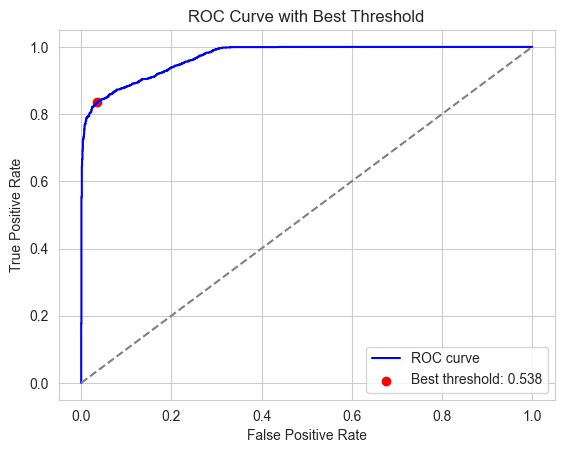

In [52]:
plt.plot(fpr_without_aug, tpr_without_aug, color='blue', label='ROC curve')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label=f'Best threshold: {thresholds_without_aug[ix]:.3f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Best Threshold')
plt.legend()
plt.show()

In [53]:
print(classification_report(y_true, y_pred_classes_no_aug, target_names=["Normal", "Pneumonia"]))

              precision    recall  f1-score   support

      Normal       0.89      0.89      0.89      2134
   Pneumonia       0.88      0.88      0.88      2020

    accuracy                           0.88      4154
   macro avg       0.88      0.88      0.88      4154
weighted avg       0.88      0.88      0.88      4154



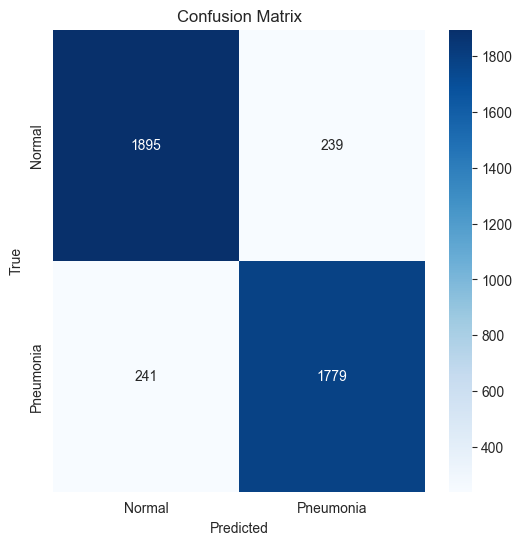

In [54]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm_without_aug, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..147.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..140.061].


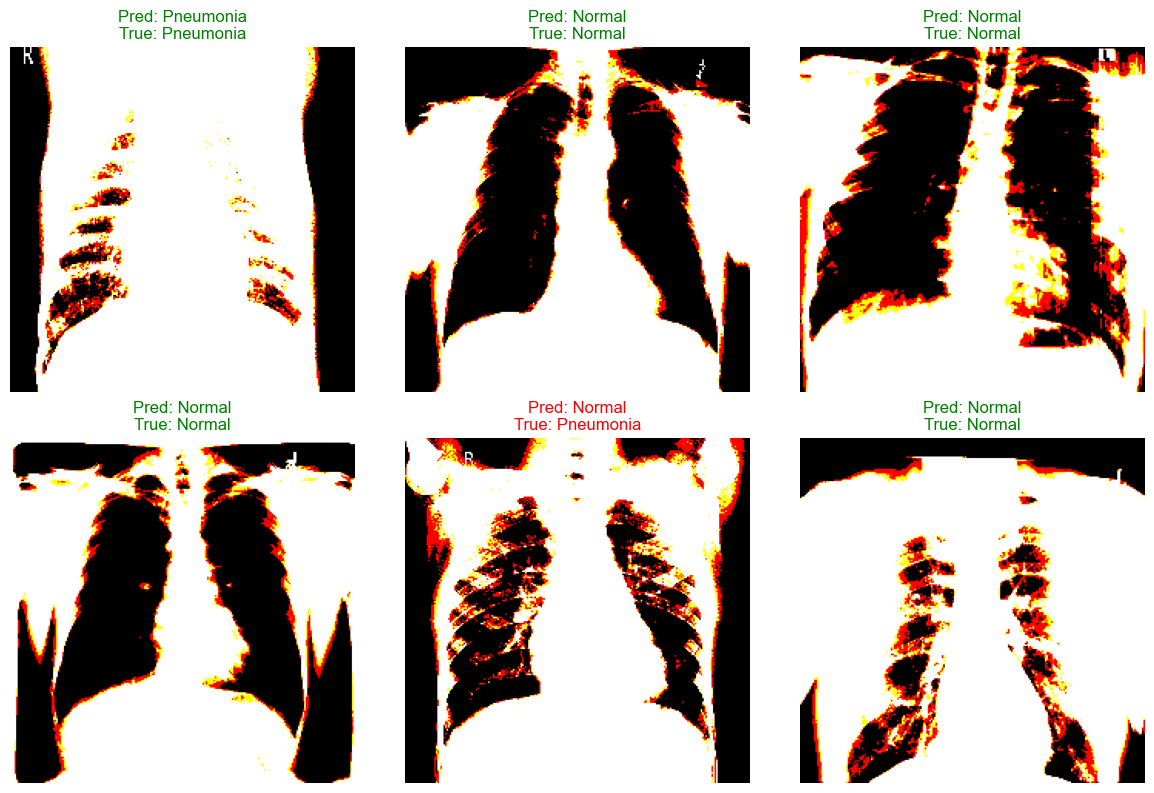

In [55]:
batch_images = test_generator_no_aug[0][0] 

plt.figure(figsize=(12, 8))

for i in range(6):
    plt.subplot(2, 3, i + 1)

    predicted_label = "Pneumonia" if y_pred_classes_no_aug[i] == 1 else "Normal"
    true_label = "Pneumonia" if y_true_no_aug[i] == 1 else "Normal"
    
    color = "green" if predicted_label == true_label else "red"
    
    plt.imshow(batch_images[i]) 
    plt.title(f"Pred: {predicted_label}\nTrue: {true_label}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()

# **Result**

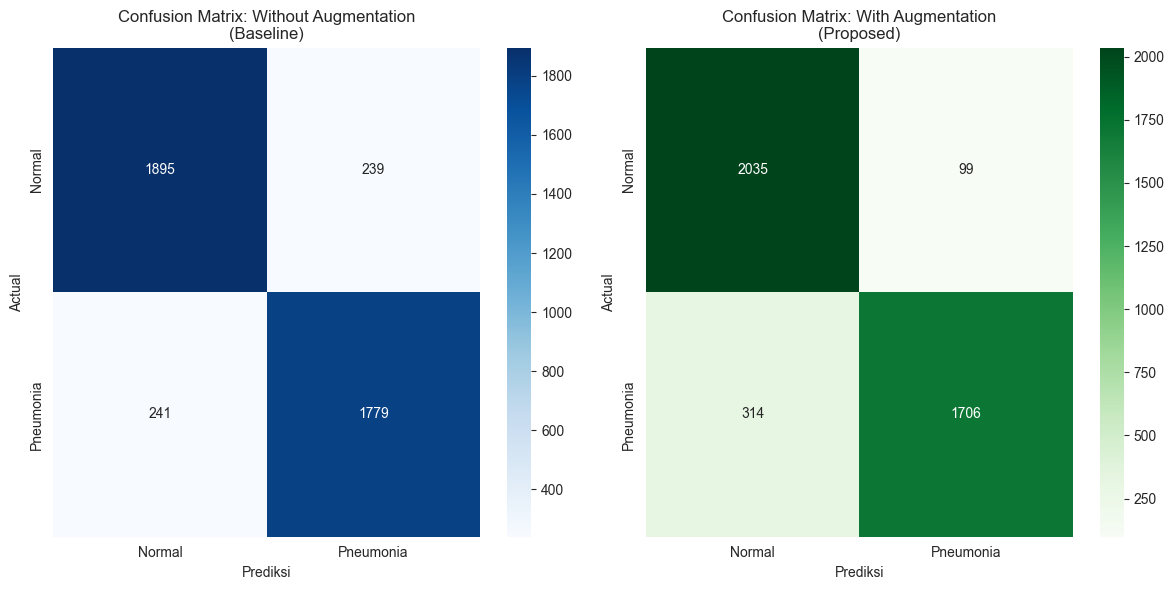

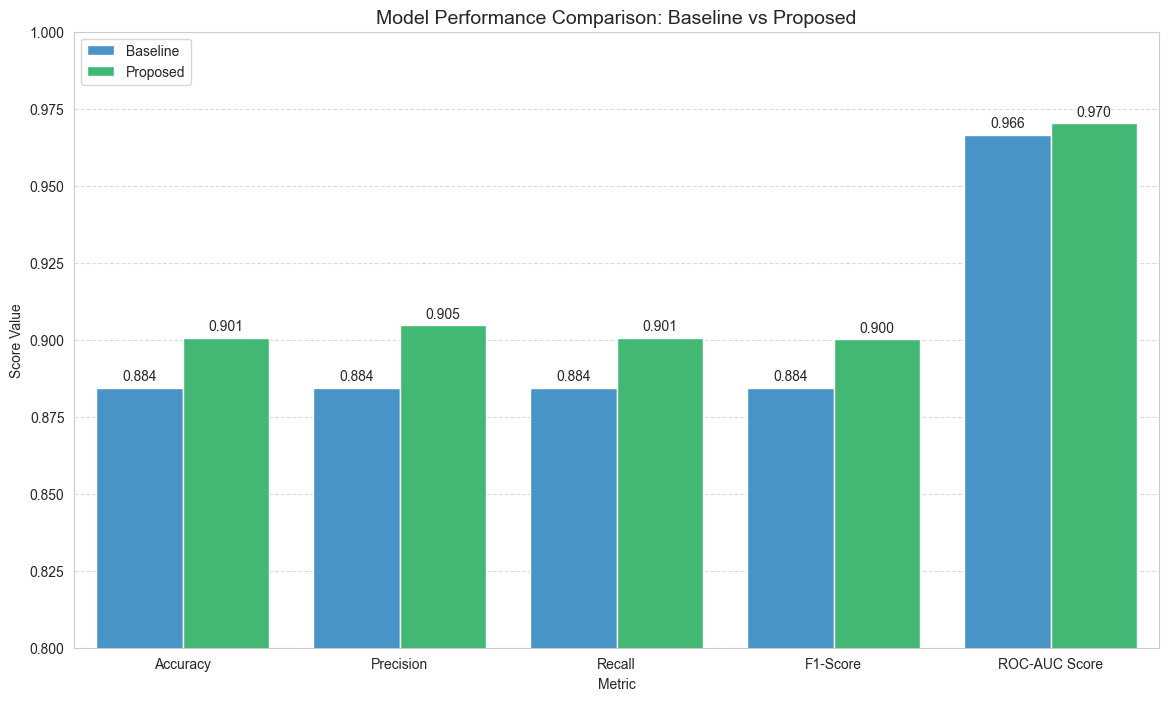

In [74]:
# Calculate metrics for both models
acc_baseline    = accuracy_score(y_true_no_aug, y_pred_classes_no_aug)
prec_baseline   = precision_score(y_true_no_aug, y_pred_classes_no_aug, average='weighted')
recall_baseline = recall_score(y_true_no_aug, y_pred_classes_no_aug, average='weighted')
f1_baseline     = f1_score(y_true_no_aug, y_pred_classes_no_aug, average='weighted')

acc_proposed    = accuracy_score(y_true, y_pred_classes)
prec_proposed   = precision_score(y_true, y_pred_classes, average='weighted')
recall_proposed = recall_score(y_true, y_pred_classes, average='weighted')
f1_proposed     = f1_score(y_true, y_pred_classes, average='weighted')

# Prepare DataFrame for visualization
metrics_data = {
    'Model': [
        'Baseline', 'Baseline', 'Baseline', 'Baseline', 'Baseline',
        'Proposed', 'Proposed', 'Proposed', 'Proposed', 'Proposed',
    ],
    'Metric': [
        'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC Score',
        'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC Score',
    ],
    'Score': [
        acc_baseline, prec_baseline, recall_baseline, f1_baseline, auc_without_aug,
        acc_proposed, prec_proposed, recall_proposed, f1_proposed, auc
    ]
}

df_metrics = pd.DataFrame(metrics_data)

# ---- Visualization 1: Confusion Matrix Comparison ----
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
labels = ['Normal', 'Pneumonia']

# Plot Baseline
sns.heatmap(cm_without_aug, annot=True, fmt='d', cmap='Blues', ax=axes[0], xticklabels=labels, yticklabels=labels)
axes[0].set_title('Confusion Matrix: Without Augmentation\n(Baseline)')
axes[0].set_xlabel('Prediksi')
axes[0].set_ylabel('Actual')

# Plot Proposed
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axes[1], xticklabels=labels, yticklabels=labels)
axes[1].set_title('Confusion Matrix: With Augmentation\n(Proposed)')
axes[1].set_xlabel('Prediksi')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# ---- Visualization 2: Bar Chart Comparison of Metrics ---
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='Metric', y='Score', hue='Model', data=df_metrics, palette=['#3498db', '#2ecc71'])

# Adding numbers above bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3)

plt.title('Model Performance Comparison: Baseline vs Proposed', fontsize=14)
plt.ylim(0.8, 1.0) # Zoom in to the 80-100% range to highlight differences
plt.ylabel('Score Value')
plt.legend(loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()